<a href="https://colab.research.google.com/github/carolstsz/datascience_beginning/blob/master/An%C3%A1lise_Netflix.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **O que eu costumo assistir na Netflix?**
##### Análise dos meus dados na plataforma

Que a Netflix é maior plataforma de streaming do mundo, não é novidade para ninguém. Avaliada em mais de [U$ 200 bilhões](https://ycharts.com/companies/NFLX/market_cap), a empresa já superou o valor de mercado da [Disney](https://https://economia.uol.com.br/noticias/bloomberg/2020/03/24/netflix-supera-disney-em-valor-de-mercado-em-meio-a-quarentenas.htm) — que recentemente também lançou seu próprio serviço de streaming. 

A liderança da empresa se dá principalmente pela interface intuitiva, a estética, o aplicativo, o catálogo de filmes/séries, além das produções originais que têm ganhado cada vez mais destaque. 

Quem nunca fez a pergunta "***Tem na Netflix?***" quando alguém recomenda um filme ou série, não é mesmo?

Com certeza saber que uma produção audiovisual está a um clique de distância é muito confortável. 

Eu fiz minha assinatura na plataforma em dezembro/2016 e desde então utilizo bastante. Assisto no computador, tv ou celular. Descubro séries novas e, principalmente, revejo a que mais gosto (veremos isso a seguir). 

**Neste notebook iremos analisar os dados referentes ao meu histórico de visualização.** 






### **Instalar bibliotecas e obter dados**

Os dados armanezados pela Netflix podem ser solicitados nesse [link](https://www.netflix.com/account/getmyinfo). 

Para essa análise o arquivo que será utilizado é o ***ViewingActivity.csv*** que contém o histórico de visualização da conta.

In [46]:
#importar bibliotecas
import pandas as pd
import matplotlib.pyplot as plt
!pip install pywaffle -q
from pywaffle import Waffle
import matplotlib.ticker as mtick
import matplotlib.pyplot as plt

In [47]:
#importar base de dados
df = pd.read_csv("/content/ViewingActivity.csv")

In [48]:
#visualização prévia dos dados
df.head()

,Profile Name,Start Time,Duration,Attributes,Title,Supplemental Video Type,Device Type,Bookmark,Latest Bookmark,Country
0,Carolina,2021-01-14 02:06:14,00:00:11,Autoplayed: user action: None;,Instant Hotel: Temporada 1: Episódio 1 (Episód...,NaN,Chrome PC (Cadmium),00:16:35,00:16:35,BR (Brazil)
1,Carolina,2021-01-14 01:23:01,00:43:11,NaN,Instant Hotel: Temporada 2: Episódio 6 (Episód...,NaN,Chrome PC (Cadmium),00:46:53,00:46:53,BR (Brazil)
2,Carolina,2021-01-14 00:45:42,00:01:20,Autoplayed: user action: None;,Instant Hotel: Temporada 2: Episódio 6 (Episód...,NaN,Chrome PC (Cadmium),00:01:29,Not latest view,BR (Brazil)
3,Luis,2021-01-13 23:55:46,00:41:47,Autoplayed: user action: Unspecified;,O Segredo dos Animais,NaN,Sony PS3,00:41:42,00:41:42,BR (Brazil)
4,Luis,2021-01-13 23:54:07,00:00:05,Autoplayed: user action: None;,Trailer: Pequenos Grandes Heróis,TRAILER,Sony PS3,00:00:05,00:00:05,BR (Brazil)


### **Tratamento dos dados**

In [49]:
#Filtrando somente para o meu usuário
df_carol = df[(df['Profile Name']=="Carolina")]

In [50]:
#Quantas variáveis e quantas entradas o dataset tem?
print('Variáveis: {}'.format(df_carol.shape[1]))
print('Entradas: {}'.format(df_carol.shape[0]))

Variáveis: 10
Entradas: 3802


In [51]:
#Dados faltantes
df_carol.isnull().sum()

Profile Name                  0
Start Time                    0
Duration                      0
Attributes                 2420
Title                         0
Supplemental Video Type    3581
Device Type                   0
Bookmark                      0
Latest Bookmark               0
Country                       0
dtype: int64

In [52]:
#filtrar apenas para Seriados (excluir filmes ou documentários)
df_seriado = df_carol[df_carol['Title'].str.contains(': Temporada', regex = False)]

In [53]:
#Criar novas colunas com o nome, a temporada e o episódio da série
df_seriado[['Name','Season','Episode']] =df_seriado['Title'].str.split(':',n=2,expand=True)

/usr/local/lib/python3.7/dist-packages/pandas/core/frame.py:3069: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[k1] = value[k2]


In [54]:
# Eliminar colunas que não serão utilizadas
df_seriado = df_seriado.drop(['Profile Name','Attributes','Title','Supplemental Video Type',
                 'Bookmark','Latest Bookmark','Country'],axis = 1)

In [55]:
df_seriado.head()

,Start Time,Duration,Device Type,Name,Season,Episode
0,2021-01-14 02:06:14,00:00:11,Chrome PC (Cadmium),Instant Hotel,Temporada 1,Episódio 1 (Episódio 1)
1,2021-01-14 01:23:01,00:43:11,Chrome PC (Cadmium),Instant Hotel,Temporada 2,Episódio 6 (Episódio 6)
2,2021-01-14 00:45:42,00:01:20,Chrome PC (Cadmium),Instant Hotel,Temporada 2,Episódio 6 (Episódio 6)
5,2021-01-13 23:40:30,00:48:30,Chrome PC (Cadmium),Instant Hotel,Temporada 2,Episódio 5 (Episódio 5)
6,2021-01-13 21:05:00,00:08:18,DefaultWidevineAndroidPhone,Instant Hotel,Temporada 2,Episódio 5 (Episódio 5)


In [56]:
# Variáveis
df_seriado.columns

Index(['Start Time', 'Duration', 'Device Type', 'Name', 'Season', 'Episode'], dtype='object')

**Dicionário das Variáveis**

* `Start Time` - Data e hora que começou a assistir o episódio.
* `Duration` - Quanto tempo assistiu daquele episódio.
* `Device Type` - Device que utilizou para assistir o episódio.
* `Name` - Nome da série.
* `Season` - Temporada da série.
* `Episode` - Nome do episódio.


In [57]:
df_seriado.dtypes

Start Time     object
Duration       object
Device Type    object
Name           object
Season         object
Episode        object
dtype: object

Converter algumas variáveis do tipo 'objeto' para formato que seja possível realizar cálculos no Pandas


In [58]:
# Converter a coluna Start Time em datetime
df_seriado['Start Time'] = pd.to_datetime(df_seriado['Start Time'], utc = True)

In [59]:
# Alterar a coluna Start Time para índice
df_seriado = df_seriado.set_index('Start Time')

# Converter o fuso horário para de São Paulo
df_seriado.index = df_seriado.index.tz_convert('America/Sao_Paulo')

# Reset do índice para Start Time voltar a ser coluna
df_seriado = df_seriado.reset_index()


In [60]:
# Converter a coluna Duration em time delta, um formato de duração (diferença entre duas datas)
df_seriado['Duration'] = pd.to_timedelta(df_seriado['Duration'])

In [61]:
df_seriado.head()

,Start Time,Duration,Device Type,Name,Season,Episode
0,2021-01-14 00:06:14-02:00,0 days 00:00:11,Chrome PC (Cadmium),Instant Hotel,Temporada 1,Episódio 1 (Episódio 1)
1,2021-01-13 23:23:01-02:00,0 days 00:43:11,Chrome PC (Cadmium),Instant Hotel,Temporada 2,Episódio 6 (Episódio 6)
2,2021-01-13 22:45:42-02:00,0 days 00:01:20,Chrome PC (Cadmium),Instant Hotel,Temporada 2,Episódio 6 (Episódio 6)
3,2021-01-13 21:40:30-02:00,0 days 00:48:30,Chrome PC (Cadmium),Instant Hotel,Temporada 2,Episódio 5 (Episódio 5)
4,2021-01-13 19:05:00-02:00,0 days 00:08:18,DefaultWidevineAndroidPhone,Instant Hotel,Temporada 2,Episódio 5 (Episódio 5)


Se observarmos acima, existem plays com segundos de duração. Normalmente são aqueles trailers que começam automaticamente ou até mesmo quando você desiste de assistir aquele episódio. 

Então para não atrapalhar a análise, vou filtrar a base para Duração acima de 5 minutos.  

In [62]:
df_seriado = df_seriado[(df_seriado['Duration'] > '0 days 00:05:00')]
df_seriado.shape

(2550, 6)

### **Análise de Dados**

**Quantas séries e quantos episódios eu assisti?**

In [63]:
print('Total de séries (diferentes) assistidas:\t {}'.format(df_seriado['Name'].value_counts().nunique()))

Total de séries (diferentes) assistidas:	 27


In [64]:
print('Total de episódios (diferentes) assistidos:\t {}'.format(df_seriado['Episode'].nunique()))

Total de episódios (diferentes) assistidos:	 985


**Quanto tempo passei assistindo?**

In [65]:
# Tempo total gasto assistindo séreis 
df_seriado['Duration'].sum()

Timedelta('42 days 09:32:50')

In [66]:
# Top 5 - tempo gasto
df_seriado.groupby('Name')['Duration'].sum().sort_values(ascending=False)[:5]

Name
A Anatomia de Grey   22 days 05:48:55
Suits                 2 days 19:21:25
Modern Family         2 days 05:54:45
Friends               2 days 05:41:51
Dexter                1 days 15:39:06
Name: Duration, dtype: timedelta64[ns]

**Quais séries eu assisti mais episódios?**

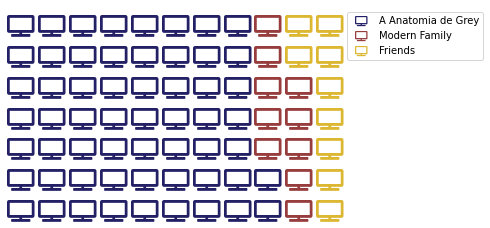

In [67]:
data = df_seriado.Name.value_counts()[:3].to_dict()

# Plotar um gráfico com as três séries mais assistidas
fig = plt.figure(
                FigureClass=Waffle,
                rows=7,
                columns=11,
                colors=("#232066", "#983D3D", "#DCB732"),
                values=data, icons='tv', icon_size=22,
                legend={'loc': 'upper left', 'bbox_to_anchor': (1,1)},
                icon_legend=True
                )
fig.set_tight_layout(False)
plt.show();

In [68]:
#top 10 
df_seriado.Name.value_counts()[:5]

A Anatomia de Grey    1233
Modern Family          206
Friends                195
Suits                  177
Dexter                  99
Name: Name, dtype: int64

In [69]:
# Criar colunas de dia da semana, hora, mês e ano
df_seriado['weekday']= df_seriado['Start Time'].dt.day_name()
df_seriado['hour'] = df_seriado['Start Time'].dt.hour
df_seriado['month'] = df_seriado['Start Time'].dt.month
df_seriado['year'] = df_seriado['Start Time'].dt.year

**Em que ano eu assisti mais séries?**

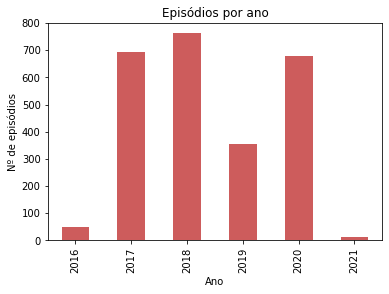

2016     49
2017    694
2018    762
2019    354
2020    679
2021     12
Name: year, dtype: int64

In [70]:
df_seriado['year'].value_counts().sort_index().plot(kind='bar',color = 'indianred')
plt.title('Episódios por ano')
plt.xlabel('Ano')
plt.ylabel('Nº de episódios')
plt.show();

df_seriado['year'].value_counts().sort_index()

Os anos que eu mais assisti foram 2017, 2018 e 2020. 
Importante observar que fiz minha assinatura em dezembro de 2016 e que esses dados contemplam apenas um mês de 2021, então podemos considerar que só o ano de 2019 foi "atípico" para mim (assisti menos da metade do que o costume). 

**Em que mês assisti mais séries?**

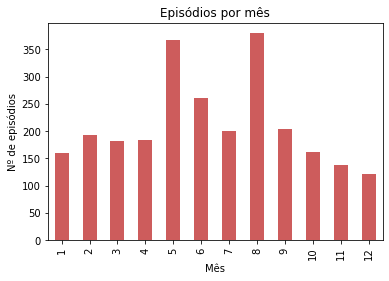

Média de episódios assistidos:	 212.50


In [71]:
df_seriado['month'].value_counts().sort_index().plot(kind='bar', color = 'indianred')
plt.title('Episódios por mês')
plt.xlabel('Mês')
plt.ylabel('Nº de episódios')
plt.show();

# Mostrar a média de episódios
print("Média de episódios assistidos:\t {:.2f}".format(df_seriado['month'].value_counts().mean()))

Ao longo desse tempo, eu assisti em média 212 episódios por mês. Destaque para os meses de maio, junho e agosto. 

**Em quais dias da semana costumo assistir mais séries?** 

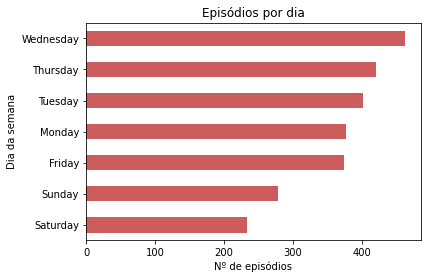

Wednesday    463
Thursday     421
Tuesday      402
Monday       377
Friday       375
Sunday       279
Saturday     233
Name: weekday, dtype: int64

In [72]:
df_seriado['weekday'].value_counts().sort_values(ascending=True).plot(kind='barh', color = 'indianred')
plt.title('Episódios por dia')
plt.xlabel('Nº de episódios')
plt.ylabel('Dia da semana')
plt.show();

# Mostrar a quantidade em cada dia
df_seriado['weekday'].value_counts().sort_values(ascending=False)


Surpreendemente, para algumas pessoas, os dias que menos assisto seriado são os finais de semana. 
Parando pensar na minha rotina, realmente tenho mais costume de assistir ao longo da semana do que sábados e domingos, que são dias que normalmente acabo tendo alguma programação com amigos ou família.

**Quais os devices mais utilizados?**

É possível assistir Netflix de diversas formas, seja computador, TV, celular, tablet ou video-games. Eu, por exemplo, assisto muito mais no navegador do computador do que na TV. 
E também gosto de fazer download de episódios no celular para assistir depois. Essa opção é tudo! (E economiza 4G, rs)

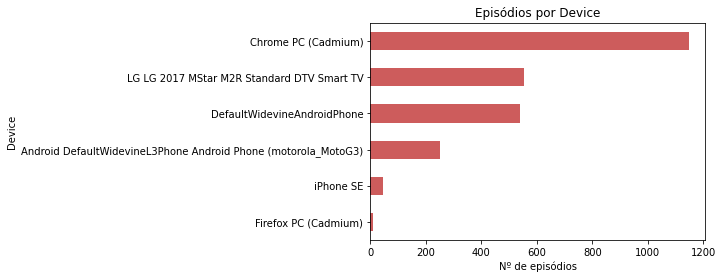

Chrome PC (Cadmium)                                               45.058824
LG LG 2017 MStar M2R Standard DTV Smart TV                        21.764706
DefaultWidevineAndroidPhone                                       21.176471
Android DefaultWidevineL3Phone Android Phone (motorola_MotoG3)     9.882353
iPhone SE                                                          1.803922
Firefox PC (Cadmium)                                               0.313725
Name: Device Type, dtype: float64

In [73]:
df_seriado['Device Type'].value_counts().sort_values(ascending=True).plot(kind='barh', color = 'indianred')
plt.title('Episódios por Device')
plt.xlabel('Nº de episódios')
plt.ylabel('Device')
plt.show();
df_seriado['Device Type'].value_counts()/df_seriado.shape[0]*100

**Análise - Greys Anatomy**

Como Greys é minha série preferida, não podia faltar uma análise só para ela. Vamos ver quais dados conseguimos extrair. 

In [74]:
#filtrar o dataset
greys = df_seriado[df_seriado['Name'].str.contains('A Anatomia de Grey', regex=False)]

In [75]:
greys['year'].value_counts()

2018    562
2020    310
2017    181
2019    179
2021      1
Name: year, dtype: int64

Comecei a ver a série em 2017 e o ano em que mais assisti foi em 2018, em que Grey's correspondeu a mais de 70% do que foi assistido. Em 2019 e 2020 essa porcentagem caiu, mas ainda assim, aproximadamente metade dos meus plays na plataforma foram para (re)assistir a série queridinha.

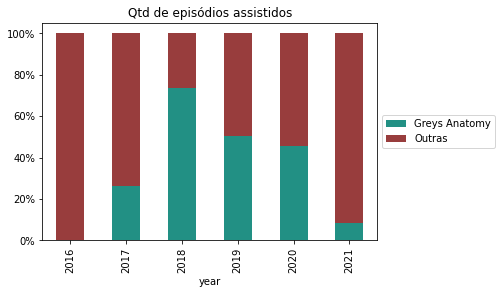

In [76]:
df_seriado.groupby(['year',df_seriado['Name']!='A Anatomia de Grey']).size().groupby(level=0).apply(
    lambda x: 100 * x / x.sum()
).unstack().plot(kind='bar',stacked=True, color =['#229084', '#983D3D'])

plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter())
plt.legend(['Greys Anatomy','Outras'],loc='center left', bbox_to_anchor=(1, 0.5))
plt.title('Qtd de episódios assistidos')
plt.show()


In [77]:
greys['Duration'].sum()

Timedelta('22 days 05:48:55')

Anteriormente eu constatei que todo o tempo que passei assistindo Grey's totalizaram 22 dias. Mas temos que concordar que essa série é ETERNA! São muitas temporadas (e olha que na Netflix não tem todas).

In [78]:
# Nº de temporadas
df_seriado.groupby('Name')['Season'].nunique().sort_values(ascending = False).head(5)

Name
A Anatomia de Grey       15
How I Met Your Mother     8
Modern Family             7
Suits                     7
Friends                   7
Name: Season, dtype: int64

Importante lembrar que essa análise é do meu histórico de visualização. Ou seja, significa que eu dei play em episódios de 15 temporadas na Netflix - a série atualmente está na 17ª temporada.

In [79]:
# As 5 temporadas mais assistidas
greys['Season'].value_counts()[:5]

 Temporada 2    222
 Temporada 3    162
 Temporada 5    150
 Temporada 8    113
 Temporada 4    112
Name: Season, dtype: int64

A temporada que eu mais assisti foi a 2ª. Pra se ter uma ideia, cada temporada tem em média 24 episódios, então 222 plays é bastante coisa.

In [80]:
# Top 10 dos episódios mais assistidos
greys['Episode'].value_counts()[:10]

 Motivo para falar (Episódio 7)                    16
 Lidando com a dor (Episódio 5)                    15
 Pega leve (Episódio 8)                            15
 É impossível negar (Episódio 4)                   13
 Muito demais (Episódio 10)                        13
 Desejando e torcendo (Episódio 14)                11
 Vovó foi atropelada por uma rena (Episódio 12)    11
 Ela se foi (Episódio 2)                           11
 Seis dias: Parte 1 (Episódio 11)                  11
 Admirável mundo novo (Episódio 4)                 11
Name: Episode, dtype: int64

Assistir 16 vezes o mesmo episódio já da pra gravar as falas, não é mesmo? hahaha.

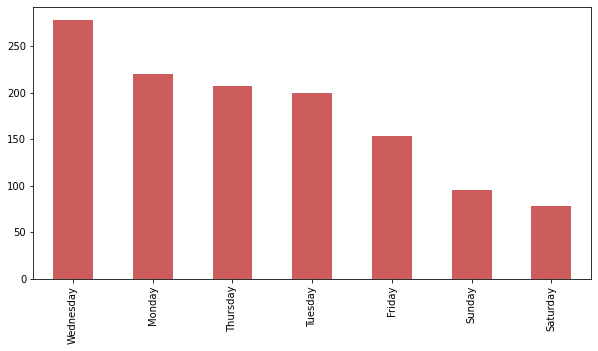

In [81]:
greys['weekday'].value_counts().plot(kind='bar',color='indianred',figsize=(10,5))

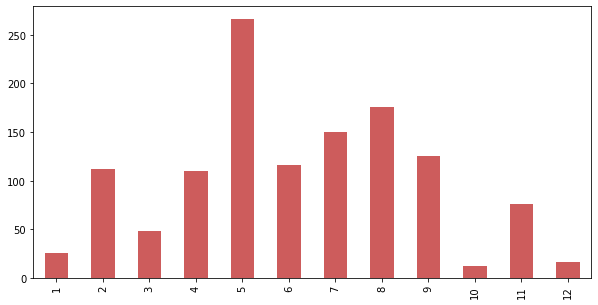

In [82]:
greys['month'].value_counts().sort_index().plot(kind='bar', color='indianred',figsize=(10,5))